### CFAV Signal decomposition

WIP. Nothing done yet!

Decompose the signal into its seasonal components.

Use the trend to calculate the availability flag.



Updates:

    19.09.2020 - First round
    28.09.2020 - Calculate HOBBIES
    16.10.2020 - Adapt to CFAV

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fcn_helpers as fhelp
import fcn_simulation as fsim
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize'] = [14, 7]
fhelp.makeFolder('results')
pd.options.display.max_rows = None
# Use v2.0 colour cycle
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Fig sizes
fig_h = 10
fig_w = 18

In [3]:
dataFolder = '~/Google Drive/order/Machine Learning Part/data/CorporacionFavorita'
xlsx_path = '~/Google Drive/order/Machine Learning Part/data/CorporacionFavorita'
graphsFolder = fhelp.fullfile(dataFolder, 'graphs_cannibalisation')

In [2]:
dept_id = 'HOBBIES_2'

In [3]:
outputBaseFolder = '~/Google Drive/order/Machine Learning Part/data/Walmart(M5)'

glob_pattern = os.path.join(os.path.expanduser(outputBaseFolder), '*', dept_id, '*', 'stores', '*.pickle')
store_level_files = glob.glob(glob_pattern)


In [4]:
store_names = ['CA_1','CA_2','CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
map_stores_to_idx = {store_names[idx_str]:idx_str for idx_str in range(0, len(store_names))}
# placeholder for the sales
stores = [ [] for idx_str in range(0, len(store_names))]

In [5]:
# Keep the preprocessing flags
#'snap_flag'
#any_event_flag = df_store['event_type_1'].notna() | df_store['event_type_2'].notna()

In [6]:
# That should be used in the stats
#df_decomposition['heartbeat_flag'].sum()/df_decomposition.shape[0]

### Go through all the stores

In [7]:
for idx, this_file in enumerate(store_level_files):
    fhelp.print_every_n(f'Reading {this_file}', idx, 38)
    df_stores = fhelp.readPickleFile(this_file)
    for df_store in df_stores:
       
        item_id = df_store.item_id.iloc[0]
        store_id = df_store.store_id.iloc[0]

        # Season-Trend decomposition using LOESS
        df_decomposition = fhelp.decompose_signal(df_store.sales, \
            period_in_days=14, minimum_heartbeat=0.25)
        
        df_decomposition['sales'] = df_store.sales

        rename_map = {iCol: f'{iCol}-{item_id}-{store_id}' for iCol in df_decomposition.columns}
        
        idx_store = map_stores_to_idx[store_id]

        stores[idx_store].append(df_decomposition.rename(columns=rename_map))

Reading /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Walmart(M5)/HOBBIES/HOBBIES_2/HOBBIES_2_100/stores/HOBBIES_2_100_stores.pickle
Reading /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Walmart(M5)/HOBBIES/HOBBIES_2/HOBBIES_2_032/stores/HOBBIES_2_032_stores.pickle
Reading /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Walmart(M5)/HOBBIES/HOBBIES_2/HOBBIES_2_104/stores/HOBBIES_2_104_stores.pickle
Reading /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Walmart(M5)/HOBBIES/HOBBIES_2/HOBBIES_2_062/stores/HOBBIES_2_062_stores.pickle


In [8]:
dates = df_store['date']
weekdays = df_store['weekday']

nameparts = item_id.split('_')
category_id = f'{nameparts[0]}'
dept_id = f'{nameparts[0]}_{nameparts[1]}'

In [9]:
outputFoldername = os.path.join(os.path.expanduser(outputBaseFolder), 'sku_decomposition', category_id, dept_id)
fhelp.makeFolder(outputFoldername)
    
for idx_store in range(0,10):

    df = pd.concat(stores[idx_store], axis=1)    
    df['date'] = dates
    df['weekdays'] = weekdays
    
    filename = os.path.join(outputFoldername, f'{store_names[idx_store]}.pickle')
    fhelp.toPickleFile(df, filename)
    print(f'Saving {filename}...')

Saving /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Walmart(M5)/sku_decomposition/HOBBIES/HOBBIES_2/CA_1.pickle...
Saving /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Walmart(M5)/sku_decomposition/HOBBIES/HOBBIES_2/CA_2.pickle...
Saving /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Walmart(M5)/sku_decomposition/HOBBIES/HOBBIES_2/CA_3.pickle...
Saving /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Walmart(M5)/sku_decomposition/HOBBIES/HOBBIES_2/CA_4.pickle...
Saving /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Walmart(M5)/sku_decomposition/HOBBIES/HOBBIES_2/TX_1.pickle...
Saving /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Walmart(M5)/sku_decomposition/HOBBIES/HOBBIES_2/TX_2.pickle...
Saving /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Walmart(M5)/sku_decomposition/HOBBIES/HOBBIES_2/TX_3.pickle...
Saving /Users/carlos.aguilar/Googl

In [10]:
store_name = 'CA_1'
filename = os.path.join(outputFoldername, f'{store_name}.pickle')
df_A = fhelp.readPickleFile(filename)

sku_A = f'HOUSEHOLD_1_283-{store_name}'
df_A.head(1)


,heartbeat_flag-HOBBIES_2_100-CA_1,trend-HOBBIES_2_100-CA_1,seasonal-HOBBIES_2_100-CA_1,residual-HOBBIES_2_100-CA_1,sales-HOBBIES_2_100-CA_1,heartbeat_flag-HOBBIES_2_138-CA_1,trend-HOBBIES_2_138-CA_1,seasonal-HOBBIES_2_138-CA_1,residual-HOBBIES_2_138-CA_1,sales-HOBBIES_2_138-CA_1,...,seasonal-HOBBIES_2_126-CA_1,residual-HOBBIES_2_126-CA_1,sales-HOBBIES_2_126-CA_1,heartbeat_flag-HOBBIES_2_119-CA_1,trend-HOBBIES_2_119-CA_1,seasonal-HOBBIES_2_119-CA_1,residual-HOBBIES_2_119-CA_1,sales-HOBBIES_2_119-CA_1,date,weekdays
0,True,0.700394,-0.616541,-0.083852,0.0,False,0.005312,0.008916,-0.014227,0.0,...,-0.650655,-0.253457,0.0,False,0.012112,0.096395,-0.108506,0.0,2015-04-25,Saturday


KeyError: 'sales-HOUSEHOLD_1_283-CA_1'

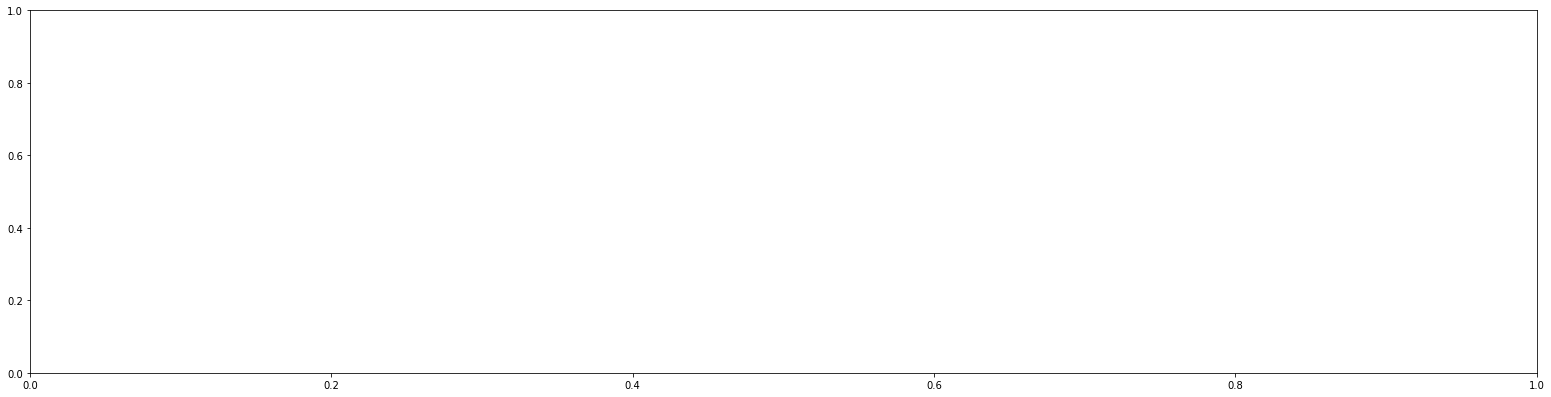

In [11]:
x_axis = df_A.date
idx_store = 0
# Plot one store
f, ax = plt.subplots(1,1,figsize=(fig_w*1.5, fig_h/1.5))

idx_axis = 0
ax.plot(x_axis, df_A['sales-' + sku_A], label=f'Sales {store_name}', 
        color=def_colours[idx_store], linewidth=2, alpha=0.75)

ax.plot(x_axis, df_A['trend-' + sku_A], label=f'LOESS trend', 
        color=def_colours[idx_store+1], linewidth=1.5, alpha=0.95)

ax.plot(x_axis, df_A['seasonal-' + sku_A], label=f'Seasonal', 
        color=def_colours[idx_store+2], linewidth=0.5, alpha=0.5)


ax.plot(x_axis, df_A['heartbeat_flag-' + sku_A], label=f'Availability', 
        color=def_colours[idx_store+3], linewidth=2.5, alpha=0.95)

plt.legend()
plt.xlabel('dates')
plt.ylabel(f'Store sales for {sku_A} ')
plt.grid(True)
plt.show()